# Dimensional Reduction

### Processor
* VOC_duration : 1min
* Wash_Out : 8min

### Sensors
+ TGS : TGS2600, TGS2602, TGS2603, TGS2610, TGS2620
+ MQ : MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135

### VOC
1. DPG ( 10%) + DPG (100%)
2. Actetic (10%) + DPG (99%)
3. Benzaldehyde (10%) + DPG (99%)
4. Keras (10%) + DPG (99%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

import datetime, time
import os, sys
from pathlib import Path
from tqdm import tqdm
from datetime import datetime, timedelta

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm
from scipy.stats import spearmanr

from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
plot_style = plt.style.available
# pd.options.display.float_format = '{:.5f}'.format
# pd.set_option('display.max_row', 500)
pd.set_option('display.max_rows', 500)

In [4]:
# plt.style.use('ggplot')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-paper')
# plt.style.use('seaborn-muted')

In [5]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [6]:
PROJECT_DIR = Path('.')
DATA_DIR = Path(PROJECT_DIR, 'data')

In [7]:
print(PROJECT_DIR, DATA_DIR)

. data


## Load Data (1-second)

In [8]:
with pd.HDFStore(PROJECT_DIR/'drug_data_1sec.h5') as store:
    print(store.info())
    df_01 = store['/drug/tgs_sensers/1sec_mean']

# df_01 = pd.read_hdf('drug_data_1s.h5', '/drug/tgs_sensors/1sec_mean')
# df_01.info()

<class 'pandas.io.pytables.HDFStore'>
File path: drug_data_1sec.h5
/drug/tgs_sensers/1sec_mean            frame        (shape->[394550,6])


In [9]:
df = df_01.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 394550 entries, ('Acetic_001', Timestamp('2023-05-07 03:44:03')) to ('Keras_725', Timestamp('2023-05-11 17:57:43'))
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   TGS2600  390472 non-null  float64
 1   TGS2602  390472 non-null  float64
 2   TGS2603  390472 non-null  float64
 3   TGS2620  390472 non-null  float64
 4   TGS2610  390472 non-null  float64
 5   TGS822   390472 non-null  float64
dtypes: float64(6)
memory usage: 31.4+ MB


In [10]:
columns = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822',
           'CYCLE', 'VOC_CYCLE', 'UNIXSTAMP']
available_senosrs = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822']
non_available_senosrs = []

In [11]:
samples = df.index.get_level_values('VOC_CYCLE').unique().tolist()
# samples

In [12]:
df = df[available_senosrs]
idx = pd.IndexSlice

In [13]:
X = []
y_voc = []
anaylsis_time = int(9 * 60) # second
aviailable_sensors_no = len(available_senosrs)
scaler = MinMaxScaler()

for sample in tqdm(samples):
    df_temp = pd.DataFrame()
    df_temp = df.loc[idx[str(sample), :], :]
    df_temp = (df_temp.fillna(method='ffill').fillna(method='bfill')[:anaylsis_time])
    df_temp = df_temp.div(df_temp.iloc[0])
    df_temp_norm = df_temp
#         df_temp_norm = scaler.fit_transform(df_temp)

    X_temp = np.asarray(df_temp_norm).flatten() 
    nan_check = np.isnan(X_temp).any()

    if (len(X_temp) >= aviailable_sensors_no*anaylsis_time) and (~nan_check):
        X_temp_scaled = scaler.fit_transform(X_temp.reshape(-1, 1)).flatten()
        X.append(X_temp_scaled)
        y_voc.append(sample.split('_')[0])
    else:
        pass
#         print(sample, len(X_temp), nan_check)

100% 728/728 [00:00<00:00, 1239.79it/s]


In [14]:
data = np.array(X)
target_voc = np.array(y_voc)

In [15]:
data.shape

(725, 3240)

In [16]:
target_voc.shape

(725,)

### PCA

In [17]:
pca = PCA(n_components=3)
X2D  = pca.fit_transform(data)

In [18]:
color_map = {
    'Acetic': 'blue',
    'Benzaldehyde': 'red',
    'DPG': 'green',
    'Keras': 'orange'
}

In [19]:
colors = [color_map[voc] for voc in target_voc]

In [20]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

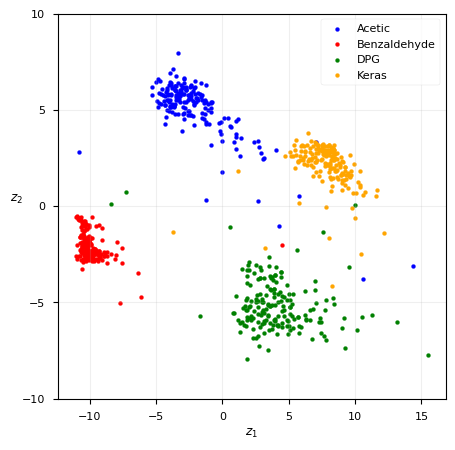

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
for voc, color in color_map.items():
    ax.scatter(X2D[target_voc == voc, 0], X2D[target_voc == voc, 1], c=color, s=8, label=voc)
# ax.scatter(X2D[:, 0], X2D[:, 1], c=colors, s=8, label=set(target_voc))
ax.set_xlabel("$z_1$")
ax.set_yticks([-10, 10, -5, 5, 0])
ax.set_ylabel("$z_2$", rotation=0)
plt.legend(loc='upper right') 
# ax.set_axisbelow(True)
ax.grid(True, alpha=0.2)
# save_fig("dataset_2d_plot")

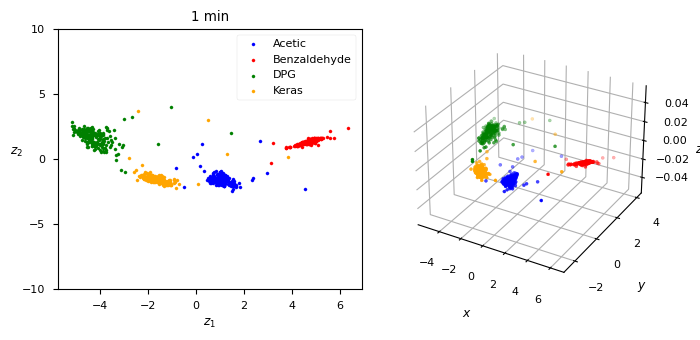

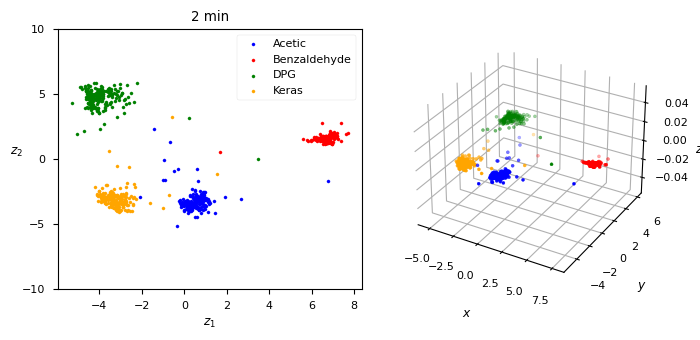

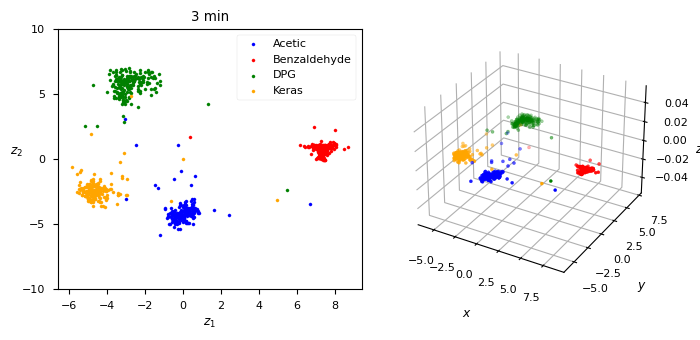

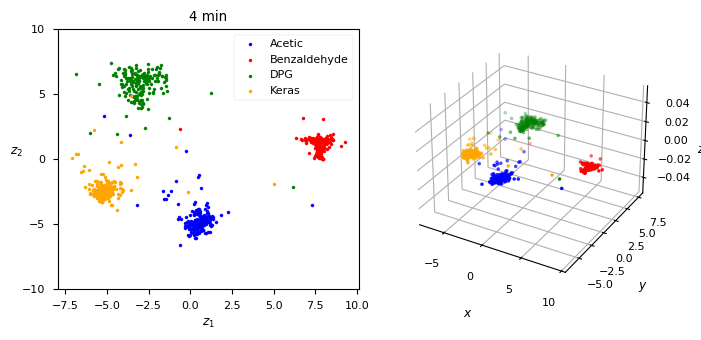

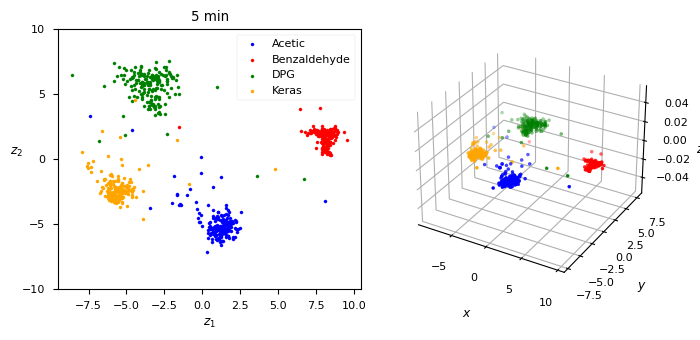

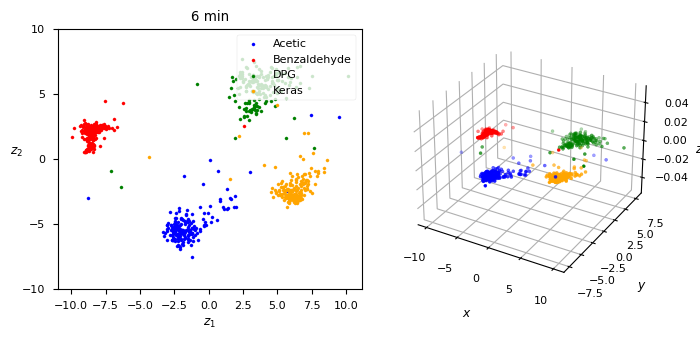

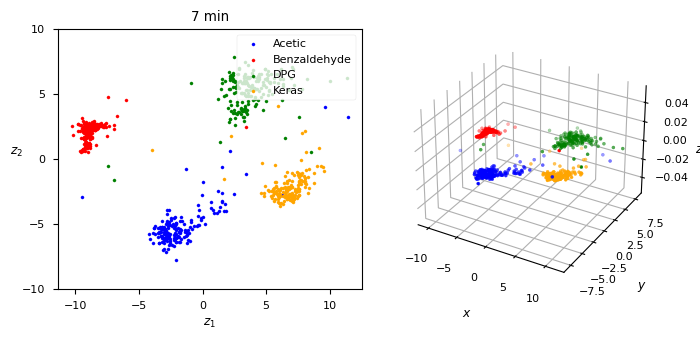

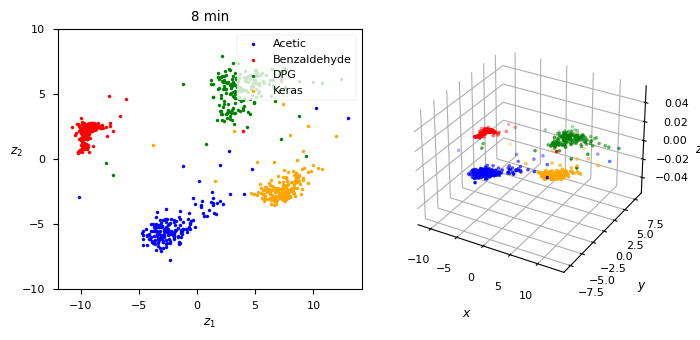

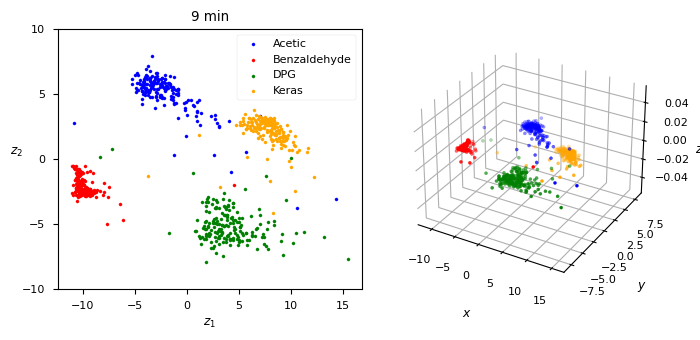

In [22]:
X = []
y_voc = []
anaylsis_time = int(9 * 60) # second
aviailable_sensors_no = len(available_senosrs)
scaler = MinMaxScaler()
df = df[available_senosrs]
idx = pd.IndexSlice

for minute in range(1, 10): 
    X = []
    y_voc = []
    anaylsis_time = int(minute * 60) # second
    aviailable_sensors_no = len(available_senosrs)
    scaler = MinMaxScaler()
    
    for sample in samples:
        df_temp = pd.DataFrame()
        df_temp = df.loc[idx[str(sample), :], :]
        df_temp = (df_temp.fillna(method='ffill').fillna(method='bfill')[:anaylsis_time])
        df_temp = df_temp.div(df_temp.iloc[0]) # 센스시그널 비율
        df_temp_norm = df_temp
#         df_temp_norm = scaler.fit_transform(df_temp)

        X_temp = np.asarray(df_temp_norm).flatten() 
        nan_check = np.isnan(X_temp).any()

        if (len(X_temp) >= aviailable_sensors_no*anaylsis_time) and (~nan_check):
            X_temp_scaled = scaler.fit_transform(X_temp.reshape(-1, 1)).flatten() # MinMax Scaling
            X.append(X_temp_scaled)
            y_voc.append(sample.split('_')[0])
        else:
            pass
    #         print(sample, len(X_temp), nan_check)

    data = np.array(X)
    target_voc = np.array(y_voc)
    
    # Data Saving
#     np.save(f'./data/npy/sensors_tgs_1sec_X_{str(int(minute))}min.npy', data)
#     np.save(f'./data/npy/sensors_tgs_1sec_y_{str(int(minute))}min.npy', target_voc)

    pca = PCA(n_components=2)
    X2D  = pca.fit_transform(data)

    color_map = {
        'Acetic': 'blue',
        'Benzaldehyde': 'red',
        'DPG': 'green',
        'Keras': 'orange'
    }
    colors = [color_map[voc] for voc in target_voc]
    
    fig = plt.figure(figsize=(7, 3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title(f'{minute} min')
    for voc, color in color_map.items():
        ax1.scatter(X2D[target_voc == voc, 0], X2D[target_voc == voc, 1], c=color, s=5, label=voc)
    ax1.set_xlabel("$z_1$")
    ax1.set_yticks([-10, 10, -5, 5, 0])
    ax1.set_ylabel("$z_2$", rotation=0)
    ax1.legend(loc='upper right') 
#     ax1.set_axisbelow(True)
#     ax1.grid(True)
#     save_fig("dataset_2d_plot")

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#     ax2.scatter(*X2D.T, s=15, c='k')
    for voc, color in color_map.items():
        ax2.scatter(X2D[target_voc == voc, 0], X2D[target_voc == voc, 1], c=color, s=5, label=voc)
    format3D(ax2)

    fig.tight_layout()

## tSNE analysis

### Data read

In [23]:
# data = np.load("./sensors_tgs_1sec_X_9min.npy")
# target_voc = np.load("./sensors_tgs_1sec_y.npy")

In [24]:
columns = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822',
           'CYCLE', 'VOC_CYCLE', 'UNIXSTAMP']
available_senosrs = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822']
non_available_senosrs = []
samples = np.unique(target_voc)

In [25]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components=2, 
            init="random", 
            learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(data)

CPU times: user 9.29 s, sys: 572 ms, total: 9.86 s
Wall time: 641 ms


In [27]:
X_reduced.shape

(725, 2)

In [28]:
target_voc.shape

(725,)

In [29]:
color_map = {'Acetic': 'blue',
             'Benzaldehyde': 'red',
             'DPG': 'green',
             'Keras': 'orange'}

In [30]:
colors = [color_map[voc] for voc in target_voc]
# colors

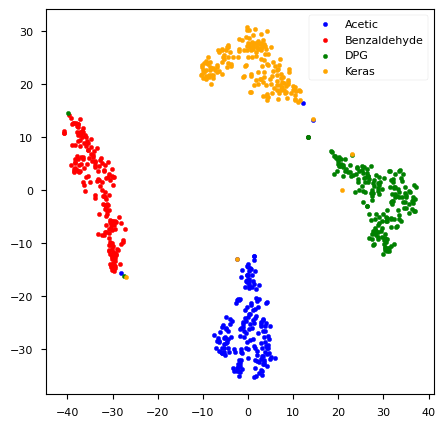

In [31]:
plt.figure(figsize=(5, 5))
for voc, color in color_map.items():
    # plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=target_voc, cmap=color_map, alpha=0.5)
    plt.scatter(X_reduced[target_voc == voc, 0], X_reduced[target_voc == voc, 1], c=color, s=10, label=voc, cmap=color_map)
# plt.axis('off')
# plt.colorbar()
plt.legend(loc='upper right') 
plt.show()

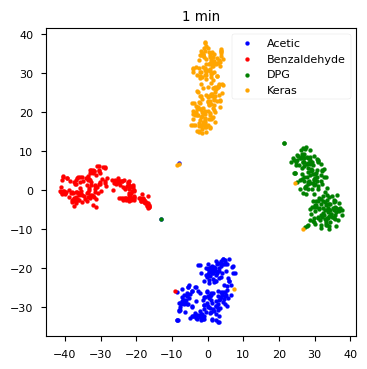

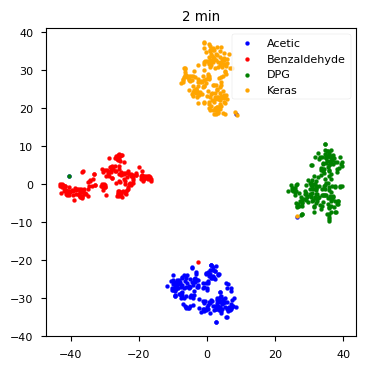

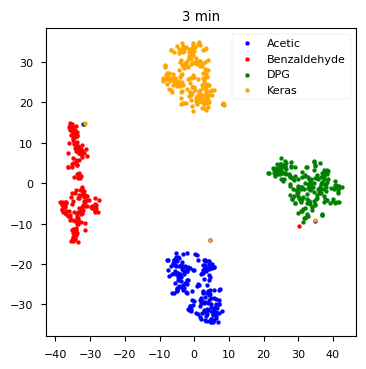

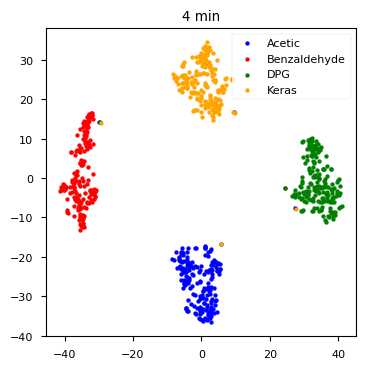

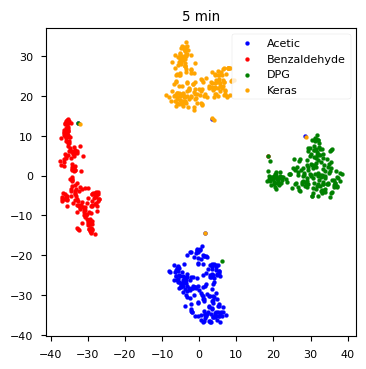

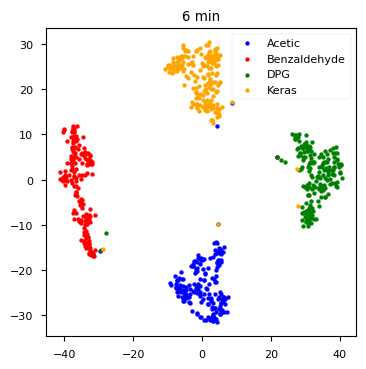

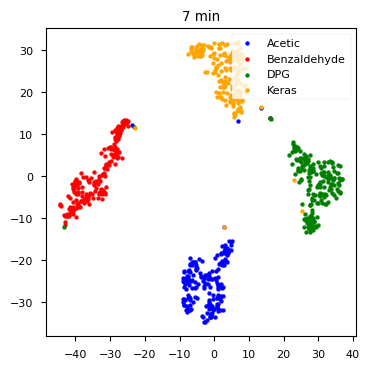

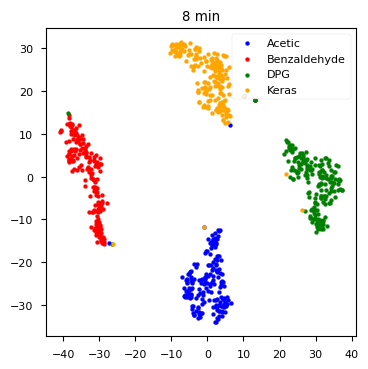

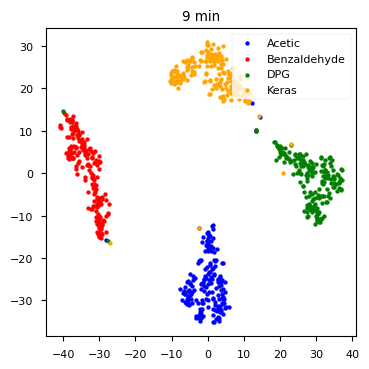

In [44]:
for minute in range(1, 10): 
    columns = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822',
               'CYCLE', 'VOC_CYCLE', 'UNIXSTAMP']
    available_senosrs = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822']
    non_available_senosrs = []
    samples = np.unique(target_voc)
    
    data = np.load(f'./data/npy/sensors_tgs_1sec_X_{int(minute)}min.npy')
    target_voc = np.load(f'./data/npy/sensors_tgs_1sec_y_{int(minute)}min.npy')
#     print(data.shape)
    
    tsne = TSNE(n_components=2, 
            init="random", 
            learning_rate="auto",
            random_state=42)
    X_reduced = tsne.fit_transform(data)
    
    color_map = {
                'Acetic': 'blue',
                'Benzaldehyde': 'red',
                'DPG': 'green',
                'Keras': 'orange'}
    colors = [color_map[voc] for voc in target_voc]
    
    plt.figure(figsize=(4, 4))
    for voc, color in color_map.items():
        # plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=target_voc, cmap=color_map, alpha=0.5)
        plt.scatter(X_reduced[target_voc == voc, 0], X_reduced[target_voc == voc, 1], c=color, s=8, label=voc, cmap=color_map)
    # plt.axis('off')
    # plt.colorbar()
    plt.legend(loc='upper right') 
    plt.title(f'{minute} min')
    plt.show()

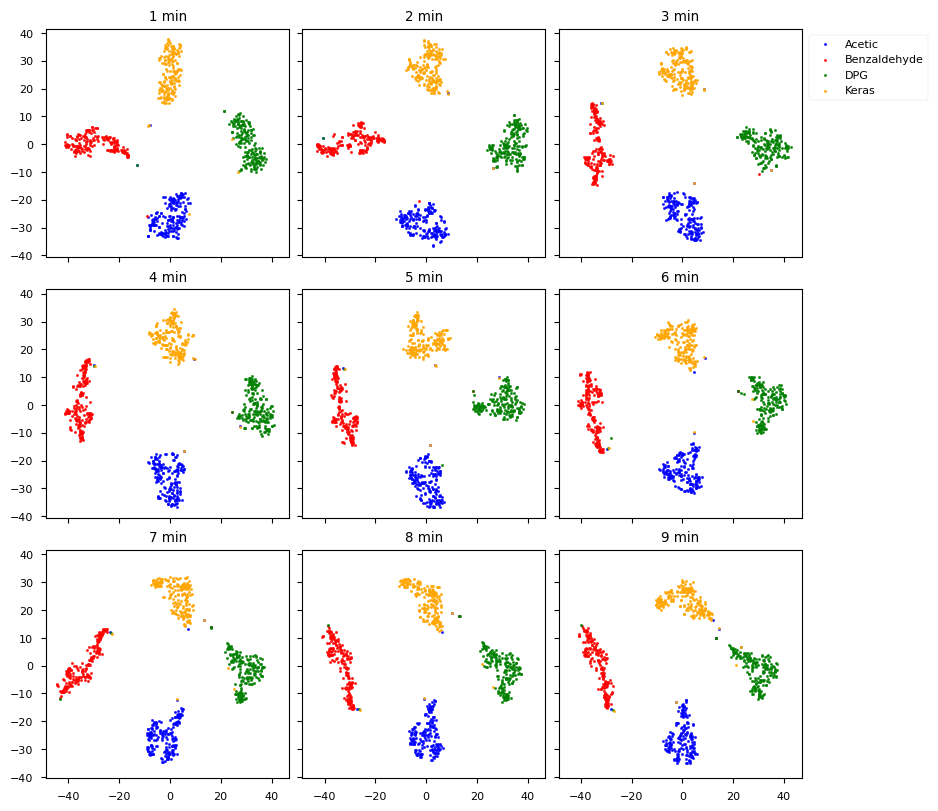

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig, axes = plt.subplots(
    ncols=3,  # 변경된 값: 3개의 서브플롯만 사용
    nrows=3,  # 변경된 값: 3개의 행으로 배치
    figsize=(8, 8), 
    constrained_layout=True, 
    sharex=True, 
    sharey=True
)

for idx, ax in enumerate(axes.flat):
    minute = idx + 1  # 분 단위로 변경
    if minute > 9:  # 변경된 값: 9분까지만 표시
        break
    
    data = np.load(f'./data/npy/sensors_tgs_1sec_X_{minute}min.npy')  # 파일 경로 수정 필요
    target_voc = np.load(f'./data/npy/sensors_tgs_1sec_y_{minute}min.npy')  # 파일 경로 수정 필요
    
    tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
    X_reduced = tsne.fit_transform(data)
    
    color_map = {'Acetic': 'blue', 'Benzaldehyde': 'red', 'DPG': 'green', 'Keras': 'orange'}
    colors = [color_map[voc] for voc in target_voc]
    
    for voc, color in color_map.items():
        ax.scatter(X_reduced[target_voc == voc, 0], X_reduced[target_voc == voc, 1], c=color, s=3, label=voc)
    ax.set_title(f'{minute} min')
handles, labels = axes[0, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.16, 0.97))
plt.show()

# UMAP Clustering